In [91]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pprint
import dimod
import qubovert

In [92]:
N = 4
np.random.seed(10)
x = np.random.rand(N,1)*20
y = np.random.rand(N,1)*10

In [93]:
x

array([[15.42641287],
       [ 0.41503899],
       [12.6729647 ],
       [14.97607765]])

In [94]:
class tsp_solver:
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        self.N = len(x)
        X, Y = np.meshgrid(np.arange(N), np.arange(N))
        self.dist = np.hypot(x[X] - x[Y], y[X] - y[Y]).squeeze()

    def get_matrix(self, alpha = 1, beta = 1):
        b = np.ones(self.N)

        A = np.kron(np.eye(self.N), b)
        AtA_1 = np.matmul(A.T, A)
        diag_1 = np.diag(2*b.T@A)    

        A2 = np.kron(b, np.eye(self.N))
        AtA_2 = np.matmul(A2.T, A2)
        diag_2 = np.diag(2*b.T@A2)

        constr = alpha*(AtA_1 - diag_1) + beta*(AtA_2 - diag_2)

        UD = np.diag(np.ones(self.N-1), k=1)
        E = np.zeros((self.N, self.N))
        E[N-1, 0] = 1

        # Create dist(i, j) on the diagonal near main and in the bottom-left corner of each block
        Q = np.kron(self.dist, UD + E)

        self.QUBO_matrix = Q + constr
        return self.QUBO_matrix
    
    def show_points(self):
        for i in range(self.N):
            name = chr(ord('A')+i)
            plt.plot(self.x[i], self.y[i], marker='o',markersize=16)
            plt.annotate(name, (x[i],y[i]), ha='center', va='center')

    def solve_brute_force_random(self):
        res = float('inf')
        self.v_ans = []
        prob_1 = np.around(1/self.N, 3)
        for i in range(200000):
            v = np.random.choice([0, 1], size=(self.N*self.N), p=[1 - prob_1, prob_1])
            val = v.T@self.QUBO_matrix@v
            if val < res:
                res = val
                self.v_ans = v
        return self.v_ans, res
    
    def get_feasible_solutions(self):
        permutations = itertools.permutations(range(self.N))

        res = float('inf')
        self.v_ans = []
        self.all_ans = {}    

        for p in permutations:
            v = np.empty(0)
            for i in range(self.N):
                plus = np.zeros(self.N)
                plus[p[i]] = 1
                v = np.concatenate([v, plus])
            val = v.T @ self.QUBO_matrix @ v
            if val < res:
                res = val
                self.v_ans = v
            self.all_ans[tuple(v)] = val

        return self.v_ans, res
            
    def get_neighbours(self, v):
        d = {}
        for i in range(self.N*self.N):
            v_near = v.copy()
            v_near[i] = 1 - v_near[i]
            d[tuple(v_near)] = v_near.T @ self.QUBO_matrix @ v_near
        return d
    
    def get_neighbours_w_other(self, v):
        ret = []
        ones = v.nonzero()[0]
        for i in range(len(ones)):
            one1 = ones[i]
            for j in range(i + 1, len(ones)):
                one2 = ones[j]
                new_one_1 = one1 - one1 % self.N + one2 % self.N
                new_one_2 = one2 - one2 % self.N + one1 % self.N

                v0 = v.copy()

                v1 = v.copy()
                v1[new_one_1] = 1

                v2 = v1.copy()
                v2[one1] = 0

                v3 = v2.copy()
                v3[new_one_2] = 1

                v4 = v3.copy()
                v4[one2] = 0

                ret.append((v0,v1,v2,v3,v4))

        return ret
    
    def solve_qubovert(self):
        QUBO_dict = {}   
        for i in range(self.QUBO_matrix.shape[0]):
            for j in range(self.QUBO_matrix.shape[1]):
                QUBO_dict[(i, j)] = self.QUBO_matrix[i][j]
        return qubovert.sim.anneal_qubo(QUBO_dict, num_anneals=10, anneal_duration=10)

    def show_res(self):
        self.show_points()
        result_output = self.v_ans.reshape((self.N, self.N))
        inds = (result_output!=0).argmax(axis=0)
        for i in range(self.N-1):
            plt.plot([x[inds[i]],x[inds[i+1]]] , [y[inds[i]],y[inds[i+1]]] , zorder = 10, linewidth = 3, linestyle = 'dashed')
        plt.plot([x[inds[self.N-1]],x[inds[0]]] , [y[inds[self.N-1]],y[inds[0]]] , zorder = 10, linewidth = 3, linestyle = 'dashed')
        

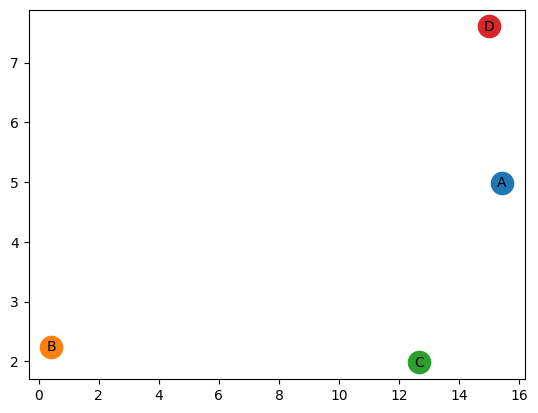

In [95]:
tsp = tsp_solver(x, y)
tsp.show_points()
QUBO_matrix = tsp.get_matrix(alpha=10000, beta=10000)

-79965.48988238961 [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]


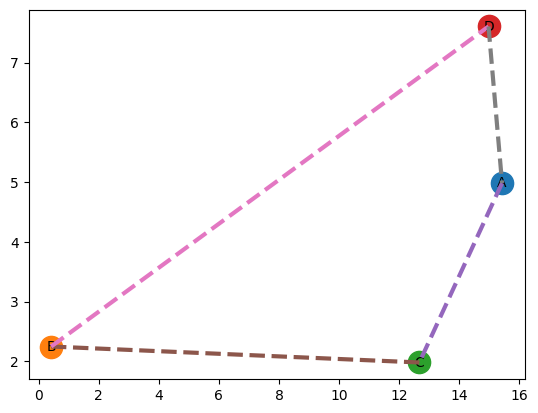

In [96]:
v_ans, res = tsp.get_feasible_solutions()
print(res, v_ans)
tsp.show_res()

In [97]:
tsp.solve_qubovert()

[AnnealResult(state={0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 1, 15: 0}, value=-79959.1, spin=False),
 AnnealResult(state={0: 0, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 0, 15: 0}, value=-79965.5, spin=False),
 AnnealResult(state={0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0}, value=-79965.5, spin=False),
 AnnealResult(state={0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0}, value=-79959.1, spin=False),
 AnnealResult(state={0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 0}, value=-79963.7, spin=False),
 AnnealResult(state={0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1}, value=-79965.5, spin=False),
 AnnealResult(state={0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 1, 9: 0, 1

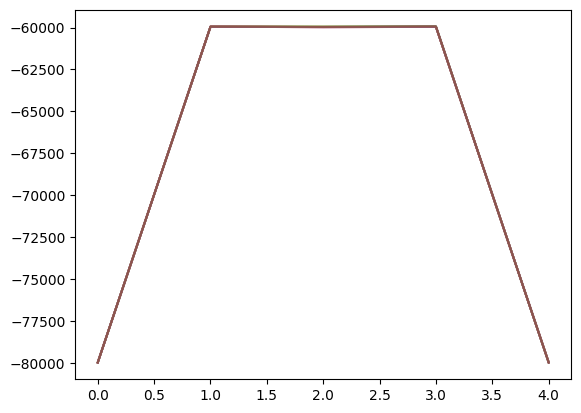

In [98]:
ways = tsp.get_neighbours_w_other(v_ans)
for way in ways:
    ress = [seq01.T @ QUBO_matrix @ seq01 for seq01 in way]
    plt.plot(ress)

In [99]:
neighbs = tsp.get_neighbours(v_ans)
x = min(neighbs, key=neighbs.get)
y = max(neighbs, key=neighbs.get)
print(neighbs[x], neighbs[y])
# sorted_neighbs = sorted(neighbs)
# print(sorted_neighbs[-1])

-59993.26603626451 -59937.71372851469


In [100]:
penalties = [0.01, 0.1, 1, 10, 100, 1000]
for p in penalties:
    QUBO_matrix = tsp.get_matrix(alpha=p, beta=p)
    v_ans, res = tsp.get_feasible_solutions()
    neighbs = tsp.get_neighbours(v_ans)
    x = min(neighbs, key=neighbs.get)
    print(p,":  ", res, neighbs[x])

    if neighbs[x] < res:
        x = np.array(x)
        neighbs_of_neighb = tsp.get_neighbours(x)
        x_of_neighb = min(neighbs_of_neighb, key=neighbs_of_neighb.get)

        print(p,":  ", res, neighbs_of_neighb[x_of_neighb])

0.01 :   34.43011761040191 6.67396373549218
0.01 :   34.43011761040191 -0.04
0.1 :   33.71011761040191 6.133963735492179
0.1 :   33.71011761040191 -0.4
1 :   26.51011761040191 0.7339637354921789
1 :   26.51011761040191 -4.0
10 :   -45.489882389598094 -53.26603626450782
10 :   -45.489882389598094 -47.188097698586766
100 :   -765.489882389598 -593.2660362645079
1000 :   -7965.489882389598 -5993.266036264507


In [101]:
# sas = SimulatedAnnealingSampler()